# Showcases of `tfplot`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tfplot

In [3]:
import numpy as np
from PIL import Image
import scipy

import skimage
import skimage.data

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

from matplotlib import rcParams, rc
from IPython.core.pylabtools import figsize

%config InlineBackend.figure_format = 'retina'

## Setup: Utilities and Data

In order to see the images generated from the plot ops, we employ a simple utility which takes a `Tensor` as an input and displays the resulting image after executing it in a TensorFlow session.

In [5]:
import tensorflow as tf
tf.InteractiveSession()

In [6]:
def execute_plot_op(image):
    print (">>> " + str(image))
    ret = image.eval()
    plt.close()
    return Image.fromarray(ret)

and some data:

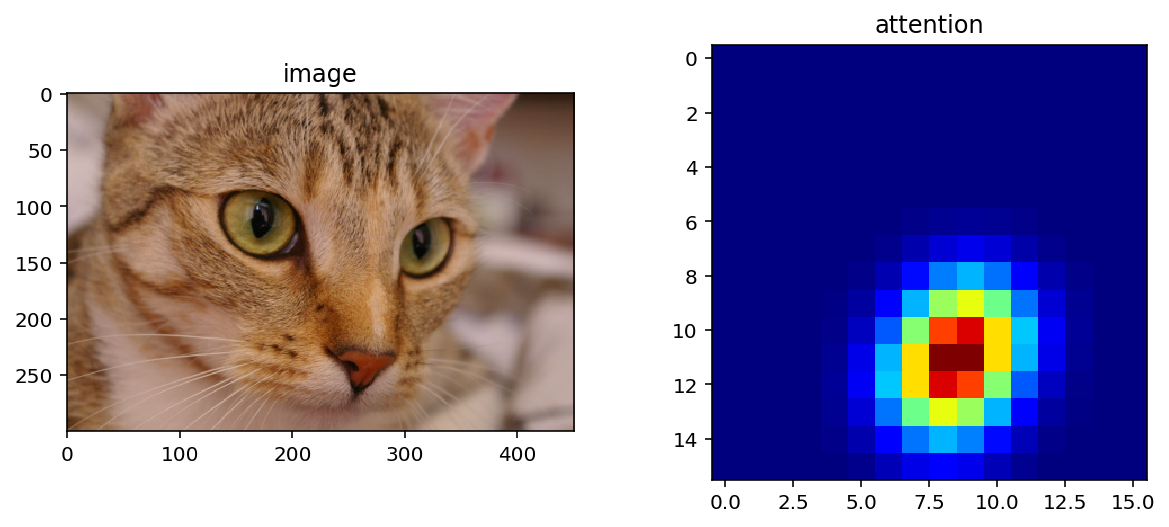

In [7]:
def fake_attention():
    import scipy.ndimage
    attention = np.zeros([16, 16], dtype=np.float32)
    attention[(12, 8)] = 1.0
    attention[(10, 9)] = 1.0
    attention = scipy.ndimage.filters.gaussian_filter(attention, sigma=1.5)
    return attention

sample_image = skimage.data.chelsea()
attention_map = fake_attention()

# display the data
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(sample_image); axs[0].set_title('image')
axs[1].imshow(attention_map, cmap='jet'); axs[1].set_title('attention')
plt.show()

And we finally wrap these numpy values into TensorFlow ops:

In [8]:
# the input to plot_op
image_tensor = tf.constant(sample_image, name='image')
attention_tensor = tf.constant(attention_map, name='attention')
print(image_tensor)
print(attention_tensor)

Tensor("image:0", shape=(300, 451, 3), dtype=uint8)
Tensor("attention:0", shape=(16, 16), dtype=float32)


## 1. Demo of `tfplot.plot()`

These examples show the usage of the most general form of the API, `tfplot.plot()`.

Conceptually, it can draw **any** matplotlib plot as a TensorFlow op. One thing to remember is that the `plot_func` function (passed to `tfplot.plot()`) should be implemented using object-oriented APIs of matplotlib, not `pyplot.XXX` APIs (or `matplotlib.pyplot.XXX`) in order to avoid thread-safety issues.

### 1.1. A basic example

>>> Tensor("Plot:0", shape=(?, ?, 3), dtype=uint8)


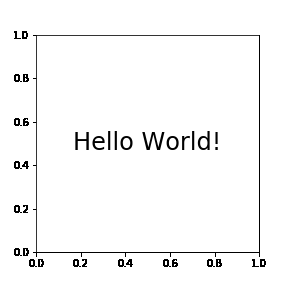

In [9]:
def test_figure():
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.text(0.5, 0.5, "Hello World!",
            ha='center', va='center', size=24)
    return fig

plot_op = tfplot.plot(test_figure, [])
execute_plot_op(plot_op)

### 1.2. with Arguments

>>> Tensor("Plot_1:0", shape=(?, ?, 3), dtype=uint8)


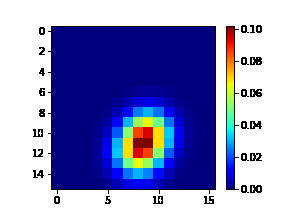

In [10]:
def figure_attention(attention):
    fig, ax = plt.subplots(figsize=(4, 3))
    im = ax.imshow(attention, cmap='jet')
    fig.colorbar(im)
    return fig

plot_op = tfplot.plot(figure_attention, [attention_tensor])
execute_plot_op(plot_op)

### 1.3. Examples of using kwargs

In [11]:
# the plot function can have additional kwargs for providing configuration points
def overlay_attention(attention, image,
                      alpha=0.5, cmap='jet'):
    
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.axis('off')
    fig.subplots_adjust(0, 0, 1, 1)  # get rid of margins
    
    H, W = attention.shape
    ax.imshow(image, extent=[0, H, 0, W])
    ax.imshow(attention, cmap=cmap,
              alpha=alpha, extent=[0, H, 0, W])
    return fig

>>> Tensor("Plot_2:0", shape=(?, ?, 3), dtype=uint8)


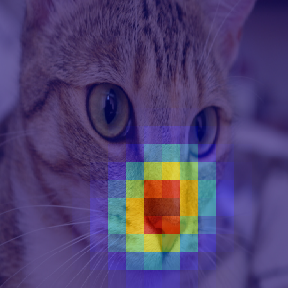

In [12]:
plot_op = tfplot.plot(overlay_attention, [attention_tensor, image_tensor])
execute_plot_op(plot_op)

>>> Tensor("Plot_3:0", shape=(?, ?, 3), dtype=uint8)


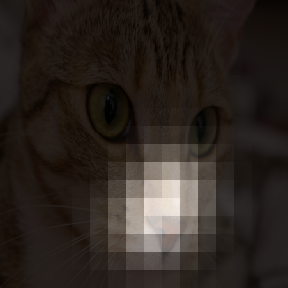

In [13]:
# the kwargs to `tfplot.plot()` are passed to the plot function (i.e. `overlay_attention`)
# during the execution of the plot operation.
plot_op = tfplot.plot(overlay_attention, [attention_tensor, image_tensor],
                      cmap='gray', alpha=0.8)
execute_plot_op(plot_op)